### Word Embedding 
É representações computacionais de texto:

* independente de contexto
* dependente de contexto

### One-hot encode
É uma representação matricial de uma fraze em uma matriz formada por zeros e uns

### TF-IDF
É feita pela frequencia das palavras utilizadas na frase palavras mais frequentes tendem a se aproximar de 0 e palavras menos frequentes tendem a ter valor mais alto

## word2vec
Atravez de um processo de treinamento, produz um vetor demonstrando matematicamente a relação entre palavras existem duas formas principais:

* CBOW: busca prever uma palavra baseadono contxto
* Skip-gram: busca prever o contexto a partir de uma palavra central

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import skipgrams
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Lambda

plt.rcParams['figure.figsize'] = (20, 8)

In [2]:
corpus = [
    'One Piece é um ótimo anime.',
    'Nunca assisti anime.',
    'One Piece é um anime.',
    ]

labels = [sentense for sentense in corpus]
labels

['One Piece é um ótimo anime.',
 'Nunca assisti anime.',
 'One Piece é um anime.']

As frases:

    

*   'One Piece é um ótimo anime.',
*   'Nunca assisti anime.',
*   'One Piece é um anime.'

contem praticamente as mesmas palavras:
*   'anime' 
*   'assisti' 
*   'nunca' 
*   'one' 
*   'piece' 
*   'um' 
*   'ótimo'

E são transformadas em um vetor 

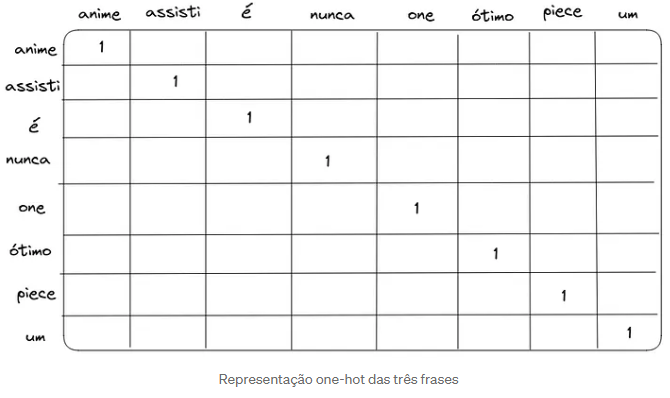





,anime,assisti,nunca,one,piece,um,ótimo
One Piece é um ótimo anime.,1,0,0,1,1,1,1
Nunca assisti anime.,1,1,1,0,0,0,0
One Piece é um anime.,1,0,0,1,1,1,0


<Axes: >

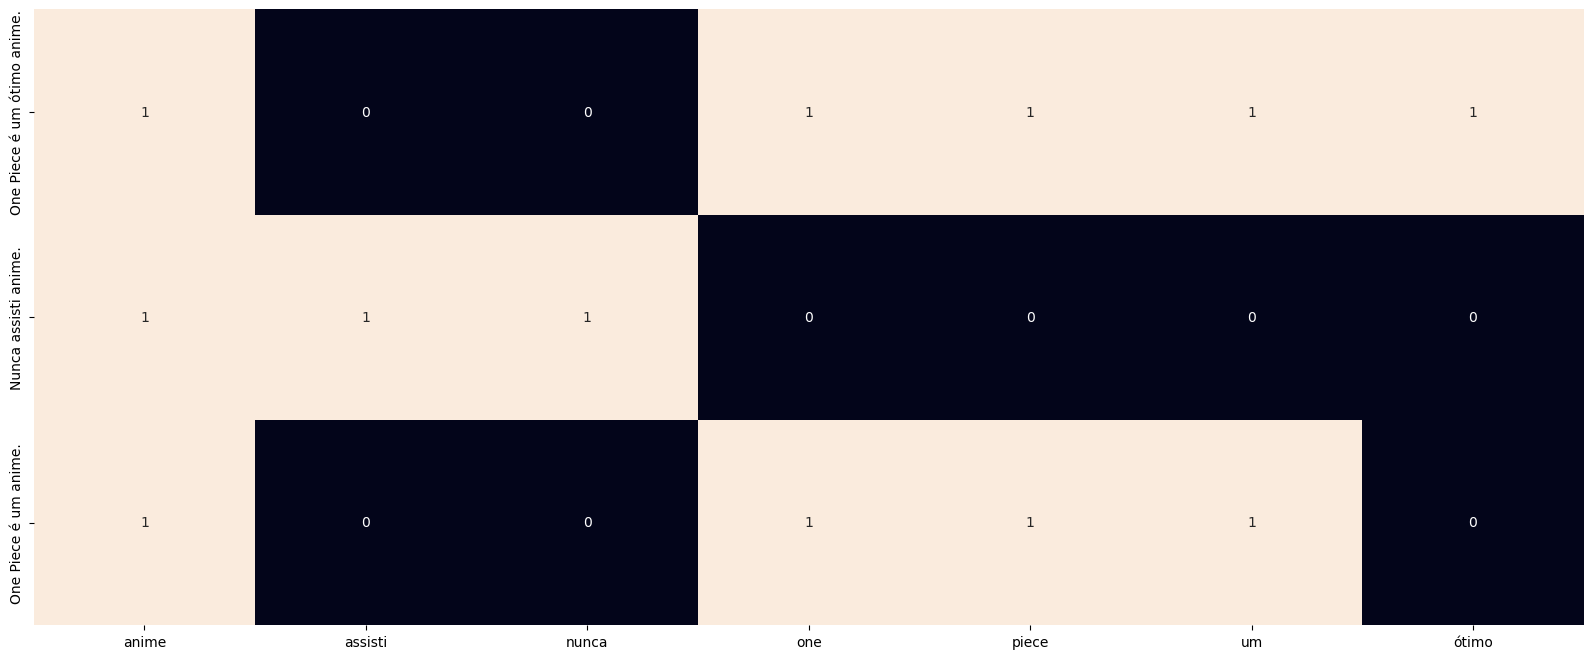

In [3]:
one_hot_vectorizer = CountVectorizer()
one_hot = one_hot_vectorizer.fit_transform(corpus).toarray()
vocab =  one_hot_vectorizer.get_feature_names_out()

df = pd.DataFrame(one_hot, columns=vocab, index=labels)
display(df)
sns.heatmap(one_hot, annot = True, cbar = False, xticklabels = vocab,
            yticklabels = labels)

A tokenização feita por TF-idf é feita pela frequencia das palavras utilizadas na frase palavras mais frequentes tendem a se aproximar de 0 e palavras menos frequentes tendem a ter valor mais alto

,anime,assisti,nunca,one,piece,um,ótimo
One Piece é um ótimo anime.,0.336315,0.000000,0.000000,0.433067,0.433067,0.433067,0.569431
Nunca assisti anime.,0.385372,0.652491,0.652491,0.000000,0.000000,0.000000,0.000000
One Piece é um anime.,0.409123,0.000000,0.000000,0.526820,0.526820,0.526820,0.000000


<Axes: >

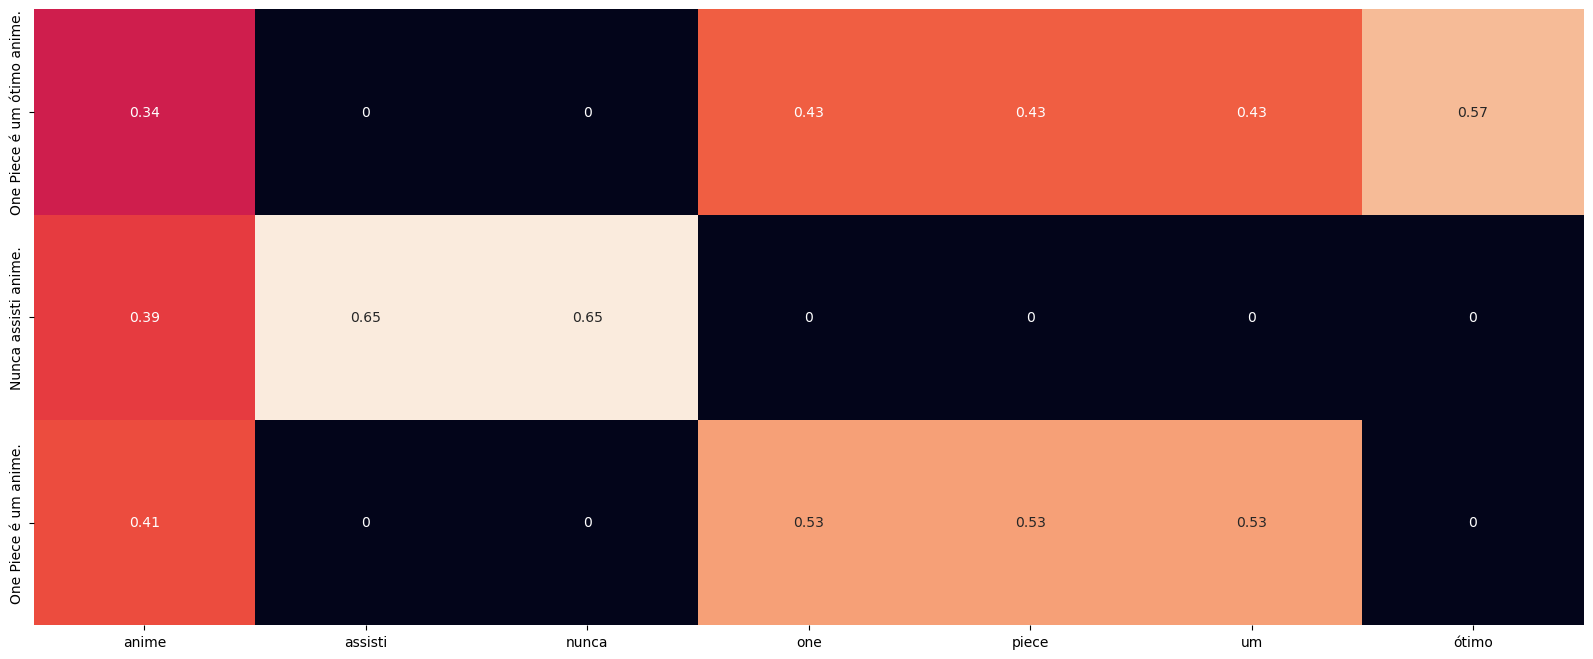

In [4]:
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(corpus).toarray()

df = pd.DataFrame(tfidf, columns=vocab, index=labels)
display(df)
sns.heatmap(tfidf, annot = True, cbar = False, xticklabels = vocab,
            yticklabels = labels)

## Skip-Gram

In [5]:
# Corpus de exemplo
corpus = [
    'One Piece é um ótimo anime.',
    'Nunca assisti anime.',
    'One Piece é um anime.',
    ]
 
# Tokenização
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
word2id = tokenizer.word_index
id2word = {v: k for k, v in word2id.items()}
vocab_size = len(word2id) +1 #para a palavra desconhecida

print('palavra para id: ',word2id)
print('id para palavra: ',id2word)
print(vocab)

palavra para id:  {'anime': 1, 'one': 2, 'piece': 3, 'é': 4, 'um': 5, 'ótimo': 6, 'nunca': 7, 'assisti': 8}
id para palavra:  {1: 'anime', 2: 'one', 3: 'piece', 4: 'é', 5: 'um', 6: 'ótimo', 7: 'nunca', 8: 'assisti'}
['anime' 'assisti' 'nunca' 'one' 'piece' 'um' 'ótimo']


In [6]:
# Gerar pares de treinamento
def generate_training_data(sentences, window_size, vocab_size):
    pairs = []
    for sentence in sentences:
        encoded = tokenizer.texts_to_sequences([sentence])[0]
        for idx, word_id in enumerate(encoded):
            context_ids = encoded[max(0, idx - window_size):idx] + encoded[idx + 1:min(len(encoded), idx + window_size + 1)]
            for context_id in context_ids:
                pairs.append((word_id, context_id))
    return pairs

window_size = 2
pairs = generate_training_data(corpus, window_size, vocab_size)
pairs = np.array(pairs)
print(pairs[:5])

[[2 3]
 [2 4]
 [3 2]
 [3 4]
 [3 5]]


In [7]:
# Construção do modelo Skip-gram
embedding_dim = 128
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1))
model.add(Flatten())
model.add(Dense(units=vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 128)            1152      
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 9)                 1161      
                                                                 
Total params: 2313 (9.04 KB)
Trainable params: 2313 (9.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# Preparação dos dados de entrada e saída
x_train = pairs[:, 0]
y_train = pairs[:, 1]

In [9]:
# Treinamento do modelo
model.fit(x_train, y_train, epochs=1000, verbose=True)

Epoch 1/1000
2/2 [==============================] - 0s 5ms/step - loss: 2.1989
Epoch 2/1000
2/2 [==============================] - 0s 2ms/step - loss: 2.1875
Epoch 3/1000
2/2 [==============================] - 0s 3ms/step - loss: 2.1775
Epoch 4/1000
2/2 [==============================] - 0s 2ms/step - loss: 2.1681
Epoch 5/1000
2/2 [==============================] - 0s 2ms/step - loss: 2.1594
Epoch 6/1000
2/2 [==============================] - 0s 2ms/step - loss: 2.1504
Epoch 7/1000
2/2 [==============================] - 0s 1ms/step - loss: 2.1419
Epoch 8/1000
2/2 [==============================] - 0s 1ms/step - loss: 2.1333
Epoch 9/1000
2/2 [==============================] - 0s 2ms/step - loss: 2.1250
Epoch 10/1000
2/2 [==============================] - 0s 1ms/step - loss: 2.1164
Epoch 11/1000
2/2 [==============================] - 0s 1ms/step - loss: 2.1085
Epoch 12/1000
2/2 [==============================] - 0s 1ms/step - loss: 2.0999
Epoch 13/1000
2/2 [==============================

In [10]:
# Obter embeddings
embeddings = model.layers[0].get_weights()[0]
print(f"Embedding da palavra 'anime': ")
print(embeddings[word2id['anime']])

Embedding da palavra 'anime': 
[-2.91062891e-01 -7.70915076e-02 -2.25354791e-01 -2.50407902e-04
 -2.36469224e-01  8.28047544e-02  1.67160784e-03 -9.71624479e-02
  1.07831381e-01 -3.67307514e-01 -1.42817022e-02  5.43681271e-02
 -1.16640581e-02 -1.97812065e-01 -4.24773470e-02  1.63077097e-02
  6.15325244e-03 -1.29694507e-01 -3.61229330e-02 -8.91784653e-02
 -1.41245648e-01  3.21573056e-02 -1.82558790e-01  5.25690615e-02
  8.29583034e-02  2.35395264e-02  2.53601730e-01  2.05280751e-01
  6.72325715e-02 -1.36712566e-01  4.77250256e-02  1.48957342e-01
 -9.20444056e-02 -4.44683246e-03  7.89539069e-02  7.22718090e-02
 -1.44161791e-01  1.61001205e-01 -5.82861602e-02  1.61444724e-01
  5.74231446e-02  3.19031715e-01 -8.96833241e-02 -8.41460377e-02
 -8.93451199e-02 -3.43691418e-03  8.73109996e-02 -1.18650943e-02
  7.93917403e-02 -8.71932805e-02 -9.51320753e-02 -2.35093385e-01
 -4.96354774e-02 -7.14649037e-02 -1.77302673e-01 -1.65327862e-01
 -6.67889118e-02 -1.08835734e-01 -2.30399698e-01 -4.2106499

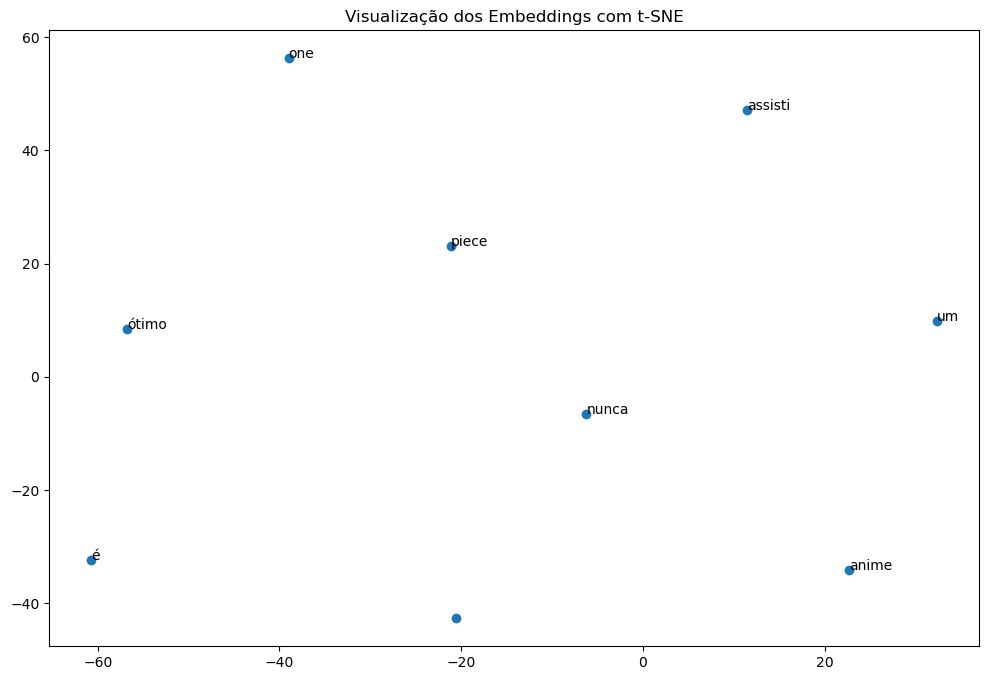

In [11]:
word_embeddings = {}
for word, key in word2id.items():
    word_embeddings[f'{word}'] = embeddings[key]

from sklearn.manifold import TSNE

# Verifique o número de amostras
n_samples = embeddings.shape[0]

# Defina o perplexity como um valor menor que n_samples
perplexity_value = min(30, n_samples - 1)  # Se n_samples < 30, ajuste perplexity para um valor menor

# Reduza para 2D com t-SNE
tsne = TSNE(n_components=2, perplexity=perplexity_value, n_iter=300)
reduced_embeddings_tsne = tsne.fit_transform(embeddings)
import matplotlib.pyplot as plt

# Defina as palavras e os embeddings reduzidos
words = list(word_embeddings.keys())
x_coords = reduced_embeddings_tsne[:, 0]
y_coords = reduced_embeddings_tsne[:, 1]

# Crie o gráfico
plt.figure(figsize=(12, 8))
plt.scatter(x_coords, y_coords)

# Adicione os rótulos das palavras
for i, word in enumerate(words):
    plt.annotate(word, (x_coords[i], y_coords[i]))

plt.title("Visualização dos Embeddings com t-SNE")
plt.show()

## CBOW

In [12]:
# Dados de exemplo
corpus = [
    'One Piece é um ótimo anime.',
    'Nunca assisti anime.',
    'One Piece é um anime.',
]

# Tokenização
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
word2id = tokenizer.word_index
id2word = {v: k for k, v in word2id.items()}
vocab_size = len(word2id) + 1  # +1 para a palavra desconhecida

print('palavra para id: ',word2id)
print('id para palavra: ',id2word)
print(vocab)

palavra para id:  {'anime': 1, 'one': 2, 'piece': 3, 'é': 4, 'um': 5, 'ótimo': 6, 'nunca': 7, 'assisti': 8}
id para palavra:  {1: 'anime', 2: 'one', 3: 'piece', 4: 'é', 5: 'um', 6: 'ótimo', 7: 'nunca', 8: 'assisti'}
['anime' 'assisti' 'nunca' 'one' 'piece' 'um' 'ótimo']


In [13]:
def generate_cbow_data(sentences, window_size, vocab_size):
    X = []
    y = []
    for sentence in sentences:
        encoded = tokenizer.texts_to_sequences([sentence])[0]
        for i, word_id in enumerate(encoded):
            context_ids = []
            for j in range(max(0, i - window_size), min(len(encoded), i + window_size + 1)):
                if j != i:
                    context_ids.append(encoded[j])
            if context_ids:
                X.append(context_ids)
                y.append(word_id)
    
    # Pad sequences to ensure fixed length
    X_padded = pad_sequences(X, maxlen=window_size*2)
    
    return np.array(X_padded), np.array(y)

# Exemplo de uso
window_size = 2
X_train, y_train = generate_cbow_data(corpus, window_size, vocab_size)

In [14]:
# Construção do modelo CBOW
embedding_dim = 128
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=window_size*2))
model.add(Lambda(lambda x: tf.reduce_mean(x, axis=1)))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 4, 128)            1152      
                                                                 
 lambda (Lambda)             (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 2313 (9.04 KB)
Trainable params: 2313 (9.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# Treinamento do modelo
model.fit(X_train, y_train, epochs=1000, verbose=True)

Epoch 1/1000
1/1 [==============================] - 0s 286ms/step - loss: 2.1908
Epoch 2/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.1843
Epoch 3/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.1778
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.1712
Epoch 5/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.1647
Epoch 6/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.1582
Epoch 7/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.1517
Epoch 8/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.1452
Epoch 9/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.1387
Epoch 10/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.1322
Epoch 11/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.1257
Epoch 12/1000
1/1 [==============================] - 0s 2ms/step - loss: 2.1191
Epoch 13/1000
1/1 [============================

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [16]:
# Obter embeddings
embeddings = model.layers[0].get_weights()[0]
print(f"Embedding da palavra 'anime': ")
print(embeddings[word2id['anime']])

Embedding da palavra 'anime': 
[ 0.4697572   0.35179237  0.21414462 -0.42525735 -0.33539352 -0.48039284
  0.5545595  -0.45204702 -0.44838753 -0.53077453  0.13690719  0.39064643
  0.4572605   0.3464843  -0.43728706 -0.49407127 -0.39096835 -0.13587947
 -0.3593804   0.46361473 -0.46492335  0.44554403 -0.5115935   0.38871986
 -0.2545797  -0.5089944   0.47265992 -0.47864905  0.4824916   0.3172417
  0.38684934 -0.5533026   0.45170742 -0.41992232  0.44112477  0.49517474
  0.5093015  -0.52183163 -0.60922134 -0.48239583  0.44223872  0.39338747
 -0.15877484 -0.41883373 -0.4074386  -0.5612273   0.52775115  0.2742225
  0.47149226  0.66036445  0.3692958   0.36245212 -0.44676885 -0.43344346
 -0.5202173  -0.42968267 -0.39502263 -0.46899065  0.36758724  0.55859625
  0.38843817  0.3853386   0.37608284  0.3690717  -0.49524817  0.57468164
  0.3553479  -0.6139278   0.47815606  0.42478466 -0.38165504  0.34841296
 -0.4214727   0.31178364 -0.6712475  -0.34308925 -0.4851796  -0.33692297
 -0.32610387 -0.383020

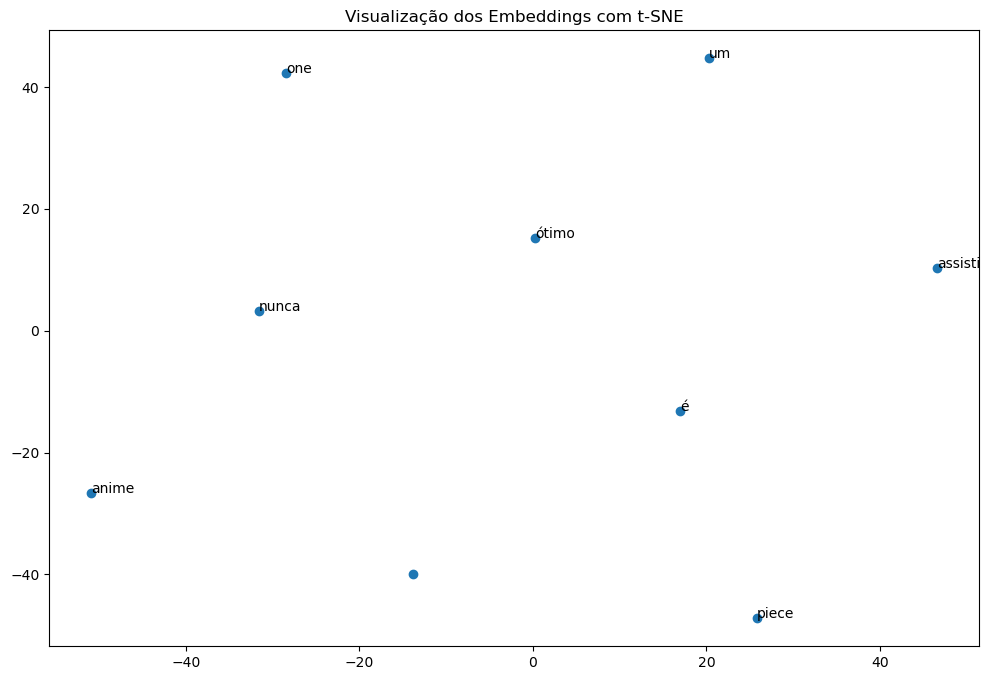

In [17]:
word_embeddings = {}
for word, key in word2id.items():
    word_embeddings[f'{word}'] = embeddings[key]

from sklearn.manifold import TSNE

# Verifique o número de amostras
n_samples = embeddings.shape[0]

# Defina o perplexity como um valor menor que n_samples
perplexity_value = min(30, n_samples - 1)  # Se n_samples < 30, ajuste perplexity para um valor menor

# Reduza para 2D com t-SNE
tsne = TSNE(n_components=2, perplexity=perplexity_value, n_iter=300)
reduced_embeddings_tsne = tsne.fit_transform(embeddings)
import matplotlib.pyplot as plt

# Defina as palavras e os embeddings reduzidos
words = list(word_embeddings.keys())
x_coords = reduced_embeddings_tsne[:, 0]
y_coords = reduced_embeddings_tsne[:, 1]

# Crie o gráfico
plt.figure(figsize=(12, 8))
plt.scatter(x_coords, y_coords)

# Adicione os rótulos das palavras
for i, word in enumerate(words):
    plt.annotate(word, (x_coords[i], y_coords[i]))

plt.title("Visualização dos Embeddings com t-SNE")
plt.show()